Import Libraries and Load NLP Pipeline

In [16]:
import json
import spacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load('en_core_web_sm')

Define Topics and Import Texts

In [17]:
# Topics to analyze
topics = [
    "text similarity measure",
    "semantic similarity",
    "information retrieval",
    "keyword extraction",
    "text summarization",
    "classification",
    "clustering",
    "topic modelling",
    "sentiment analysis",
    "large language models"
]

# Import texts and group by year
files = [
    'papers-semeval-2021.json',
    'papers-semeval-2022.json',
    'papers-semeval-2023.json',
    'papers-semeval-2024.json'
]

corpora_by_year = {}

for filename in files:
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
        year = filename[15:19]
        corpora_by_year[year] = [item['abstract'] for item in data]

Preprocess Abstracts

In [18]:
def preprocess_texts(abstracts):
    processed_texts = []
    for abstract in abstracts:
        doc = nlp(abstract.lower())
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        processed_texts.append(' '.join(lemmas))
    return processed_texts

# Preprocess abstracts by year
preprocessed_by_year = {
    year: preprocess_texts(abstracts) for year, abstracts in corpora_by_year.items()
}

Use TF-IDF to score topic mentions

In [22]:
def calculate_normalized_tfidf_scores(preprocessed_by_year, topics):
    topic_trends = {topic: [] for topic in topics}
    years = sorted(preprocessed_by_year.keys())

    for year in years:
        corpus = preprocessed_by_year[year]
        vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), min_df=0.01)
        tfidf_matrix = vectorizer.fit_transform(corpus)
        vocab = vectorizer.get_feature_names_out()

        for topic in topics:
            topic_tokens = topic.split()
            topic_score = sum(
                sum(tfidf_matrix[:, vocab.tolist().index(token)].toarray().flatten())
                for token in topic_tokens if token in vocab
            )
            normalized_score = topic_score / len(corpus) if len(corpus) > 0 else 0
            topic_trends[topic].append(normalized_score)

    return topic_trends, years

Calculate topic trends

In [23]:
topic_trends, years = calculate_normalized_tfidf_scores(preprocessed_by_year, topics)

for year_idx, year in enumerate(years):
    print(f"\nYear: {year}")
    for topic in topics:
        print(f" - {topic}: {topic_trends[topic][year_idx]:.4f}")


Year: 2021
 - text similarity measure: 0.0389
 - semantic similarity: 0.0121
 - information retrieval: 0.0154
 - keyword extraction: 0.0117
 - text summarization: 0.0319
 - classification: 0.0230
 - clustering: 0.0000
 - topic modelling: 0.0020
 - sentiment analysis: 0.0077

Year: 2022
 - text similarity measure: 0.0564
 - semantic similarity: 0.0356
 - information retrieval: 0.0130
 - keyword extraction: 0.0109
 - text summarization: 0.0316
 - classification: 0.0300
 - clustering: 0.0000
 - topic modelling: 0.0024
 - sentiment analysis: 0.0415

Year: 2023
 - text similarity measure: 0.0363
 - semantic similarity: 0.0106
 - information retrieval: 0.0256
 - keyword extraction: 0.0050
 - text summarization: 0.0292
 - classification: 0.0263
 - clustering: 0.0000
 - topic modelling: 0.0000
 - sentiment analysis: 0.0379

Year: 2024
 - text similarity measure: 0.0585
 - semantic similarity: 0.0378
 - information retrieval: 0.0114
 - keyword extraction: 0.0082
 - text summarization: 0.0454
 

Visualize Topic Trends

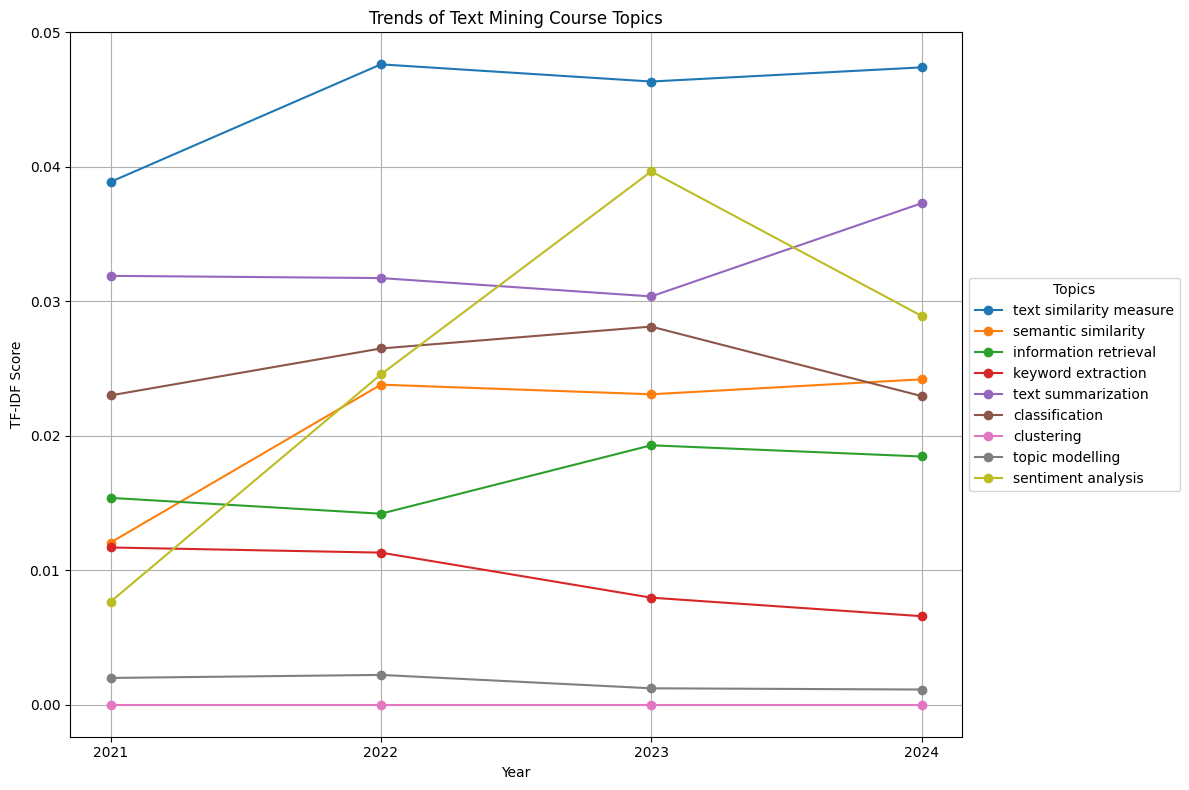

In [24]:
# Smooth trends using rolling average
def smooth_trends(topic_trends):
    smoothed_trends = {}
    for topic, scores in topic_trends.items():
        smoothed_trends[topic] = pd.Series(scores).rolling(window=2, center=True, min_periods=1).mean().tolist()
    return smoothed_trends

# Convert trends into a matrix for visualization
topic_matrix = np.array([smooth_trends(topic_trends)[topic] for topic in topics])

# Plot trends for each topic
plt.figure(figsize=(12, 8))
for idx, topic in enumerate(topics):
    plt.plot(years, topic_matrix[idx], marker='o', label=topic)

plt.title("Trends of Text Mining Course Topics")
plt.xlabel("Year")
plt.ylabel("TF-IDF Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Topics")
plt.grid(True)
plt.tight_layout()
plt.show()